In [1]:
import algorithms
import treespace
import logging 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from utils import calculate_l, generate_requests

## Plotting Requests Distribution

### Level-wise zipf distribution
In this distribution, the nodes in the same tree level have the same probability of being requested, and this probability is based on a zipf distribution for the level of the nodes from bottom to top of the tree.

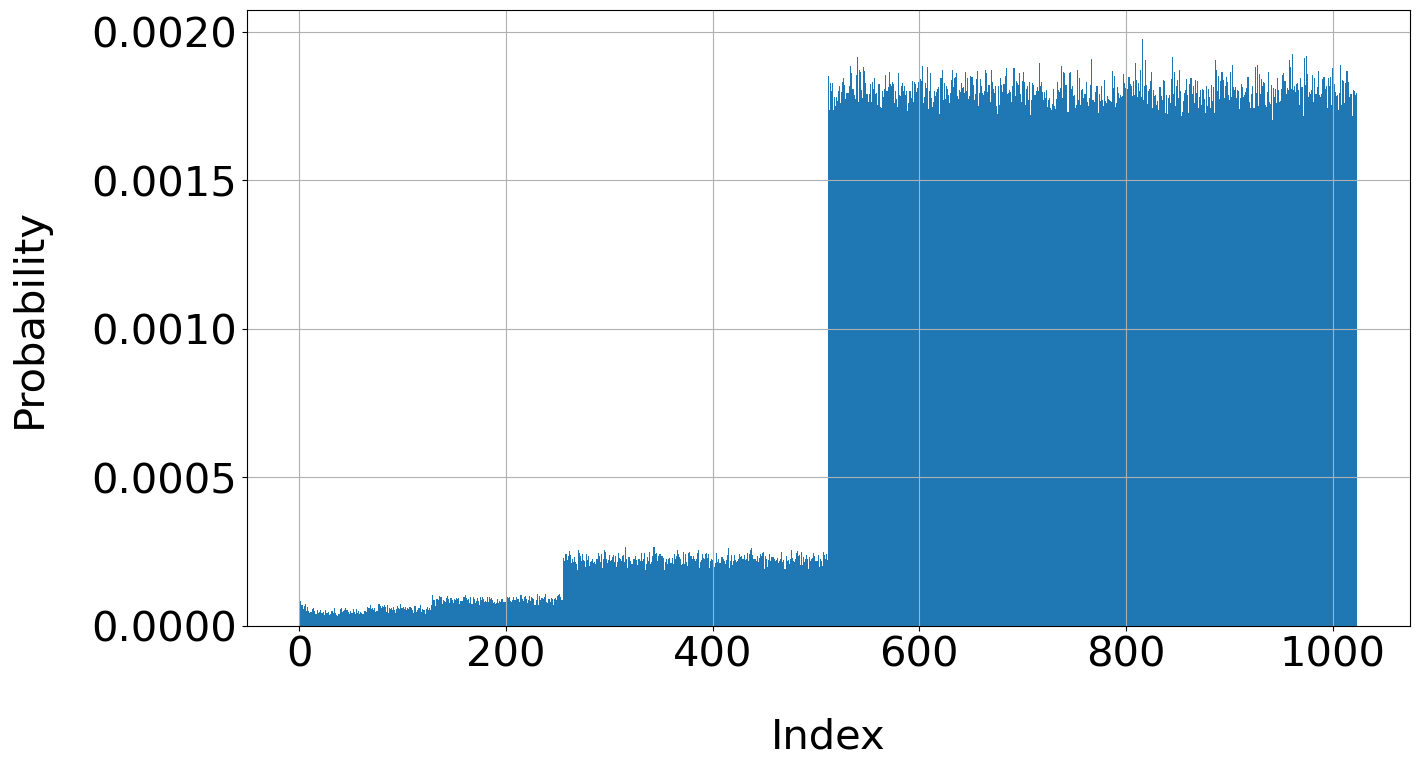

In [2]:
n = 2**10
size = 1000000
perm = None
reqs = np.array(generate_requests(n = 10, perm=perm, a=4, size=size, dist="zipf", rand_type="level"))
plt.figure(figsize=(15,8))
plt.hist(reqs, bins=np.arange(0.5,n,1), density=True)
plt.grid()
#plt.title("Distribution of Requested Indices")
plt.xlabel("Index", fontsize=30)
plt.ylabel("Probability", fontsize=30)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.yaxis.labelpad = 30
ax.xaxis.labelpad = 30
plt.savefig("results/request_distribution_zipf_no_perm.png", dpi=300, bbox_inches='tight')

### Index-wise exponential distribution
In this distribution, the nodes have a geometric probability based on their node index from bottom to top. 

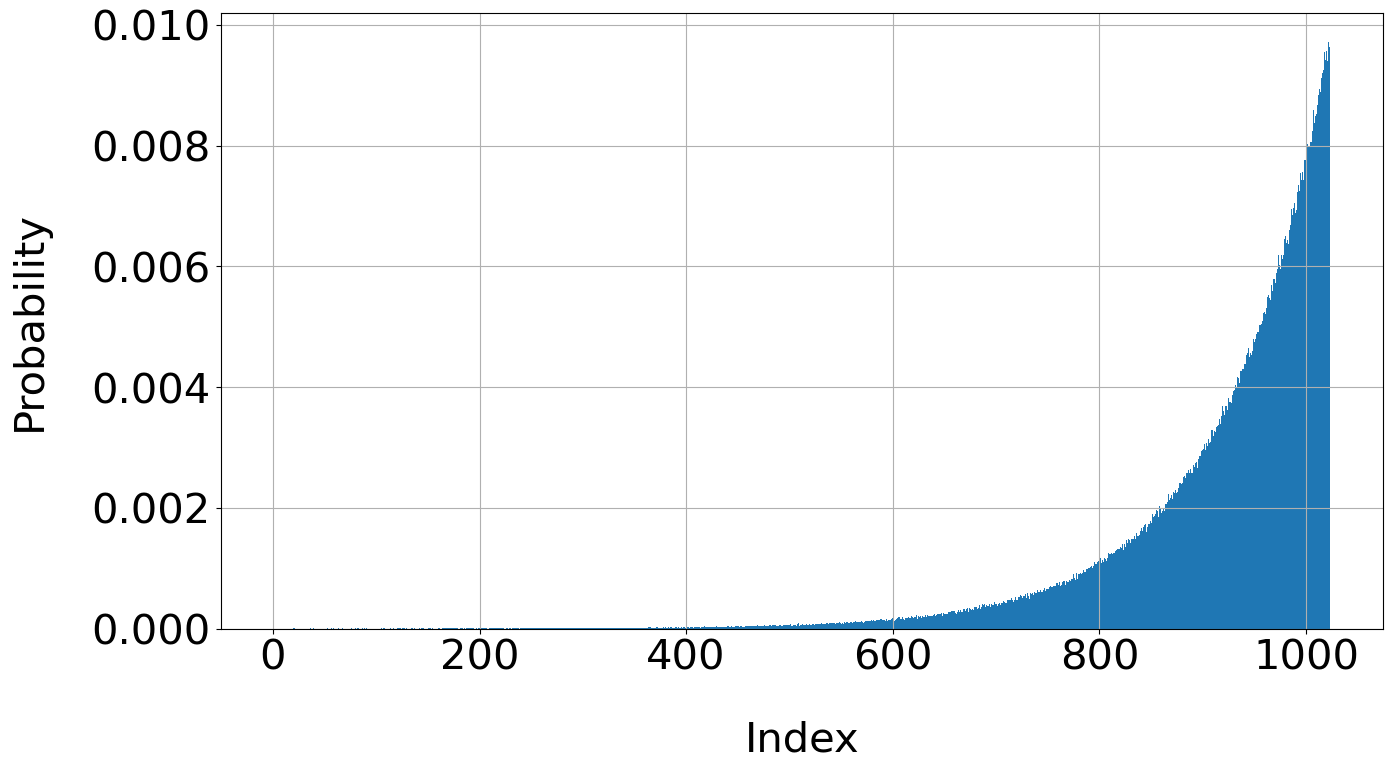

In [3]:
n = 2**10
size = 1000000
perm = None
reqs = np.array(generate_requests(n = n, perm=perm, a=10/n, size=size, dist="geo", rand_type="index"))
plt.figure(figsize=(15,8))
plt.hist(reqs, bins=np.arange(0.5,n,1), density=True)
plt.grid()
plt.xlabel("Index", fontsize=30)
plt.ylabel("Probability", fontsize=30)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.yaxis.labelpad = 30
ax.xaxis.labelpad = 30
plt.savefig("results/request_distribution_geo_no_perm.png", dpi=300, bbox_inches='tight')

## Running the algorithm

In [4]:
# setting the log level
# set the log level to log all the requests
# set the log level to debug for a more detailed description of each operation
logging.basicConfig(filename='logs.txt', format='%(levelname)s:%(message)s', level=logging.WARNING)

We first need to run the algorithm for different values of cache size `k`, given an specific number of `n`, `repeats`, and `a` which could be easily tweaked.

In order to generate the results for the zipf distribution, the parameters should be specified as follows:
- `n = 10`
- `a = 4`
- `dist = "zipf"`
- `perm = None`
- `rand_type = "level`

In order to generate the results for the exponential distribution, the parameters should be specified as follows:
- `n = 10`
- `a = 10/2**10`
- `dist = "geo"`
- `perm = None`
- `rand_type = "index"`

You can automatically choose these values by setting the `EXPERIMENT` parameter to `zipf` or `geo`.

In [5]:
# choose the EXPERIMENT between 'zipf' and 'geo'
EXPERIMENT = "geo"

In [6]:
results_df = pd.DataFrame(columns = ["n", "k", "len", "alg", "tree_caching"])

# setting the parameters
repeats = 10
size = 5000
n = 10
perm = None
if EXPERIMENT == "zipf":
    a = 4
    dist = "zipf"
    rand_type = "level"
    
elif EXPERIMENT == "geo":
    a = n / (2 ** n)
    dist = "geo"
    rand_type = "index"

n_dist = n if rand_type == "level" else 2**n

tree = treespace.BinaryTree(n)
tree_caching = algorithms.TreeCaching(tree)
for repeat in range(repeats):
    print(f"-- repeat ={repeat}") 
    requests_idx = list(generate_requests(n=n_dist, perm=perm, a=a, size=size, dist=dist, rand_type=rand_type))
    req_len = len(requests_idx)
    requests = list(map(lambda x: tree.nodes[x - 1], requests_idx))
    
    for k in tqdm(range(4, 2**(n-1), 1)):
        alg = algorithms.RandomBucket(tree)
        alg_cost = alg.serve_requests(requests, k, calculate_l(n), 1)
        tree_c_cost = tree_caching.serve_requests(requests, k, 1)
        
        # Uncomment the following for printing the costs
        # print("---- k =", k)
        # print(f"-------- Request Len = {req_len}")
        # print(f"-------- Alg Cost = {alg_cost}")
        # print(f"-------- Tree C Cost = {tree_c_cost}")
        
        temp_df = pd.DataFrame([[n,k,req_len,alg_cost,tree_c_cost]], columns=['n','k','len','alg','tree_caching'])
        results_df = pd.concat([results_df, temp_df], ignore_index=True)

-- repeat =0


  0%|          | 0/508 [00:00<?, ?it/s]

100%|██████████| 508/508 [01:58<00:00,  4.30it/s]


-- repeat =1


100%|██████████| 508/508 [01:48<00:00,  4.68it/s]


-- repeat =2


100%|██████████| 508/508 [01:39<00:00,  5.11it/s]


-- repeat =3


100%|██████████| 508/508 [02:16<00:00,  3.73it/s]


-- repeat =4


100%|██████████| 508/508 [02:11<00:00,  3.86it/s]


-- repeat =5


100%|██████████| 508/508 [02:12<00:00,  3.82it/s]


-- repeat =6


100%|██████████| 508/508 [03:11<00:00,  2.66it/s]


-- repeat =7


100%|██████████| 508/508 [02:39<00:00,  3.18it/s]


-- repeat =8


100%|██████████| 508/508 [02:30<00:00,  3.37it/s]


-- repeat =9


100%|██████████| 508/508 [02:06<00:00,  4.01it/s]


Calculating the average cost of each algorithm

In [7]:
results_df['alg_ratio'] = results_df['alg']/results_df['len']
results_df['tc_ratio'] = results_df['tree_caching']/results_df['len']

In [8]:
results_arr = results_df[['n','k','alg_ratio','tc_ratio']].values.copy().astype("float")
res_smooth = np.array([[]]).reshape((0,4))
for n in range(10,11):
    for k in range(4, 2**(n-1), 1):
        res = np.mean(results_arr[(results_arr[:,0] == n) & (results_arr[:,1] == k)], axis=0).reshape((1,4))
        res_smooth = np.append(res_smooth, res, axis=0)

## Saving the results
The results of different experiments are saved in the directory `data`.

In [9]:
n = 10
data = res_smooth[res_smooth[:, 0]==n][:, [1,2,3]]

if EXPERIMENT == "zipf":
    with open('data/zipf_no_perm_levelwise_data.npy', 'wb') as f:
        np.save(f, data)

elif EXPERIMENT == "geo":
    with open('data/geo_no_perm_data.npy', 'wb') as f:
        np.save(f, data)

## Plotting
### Loading the data
In cases when you already have the data you can start fro here to just load and plot the results.

In [10]:
if EXPERIMENT == "zipf":
    with open('data/zipf_no_perm_levelwise_data.npy', 'rb') as f:
        data = np.load(f)

elif EXPERIMENT == "geo":
    with open('data/geo_no_perm_data.npy', 'rb') as f:
        data = np.load(f)

### Plotting the data

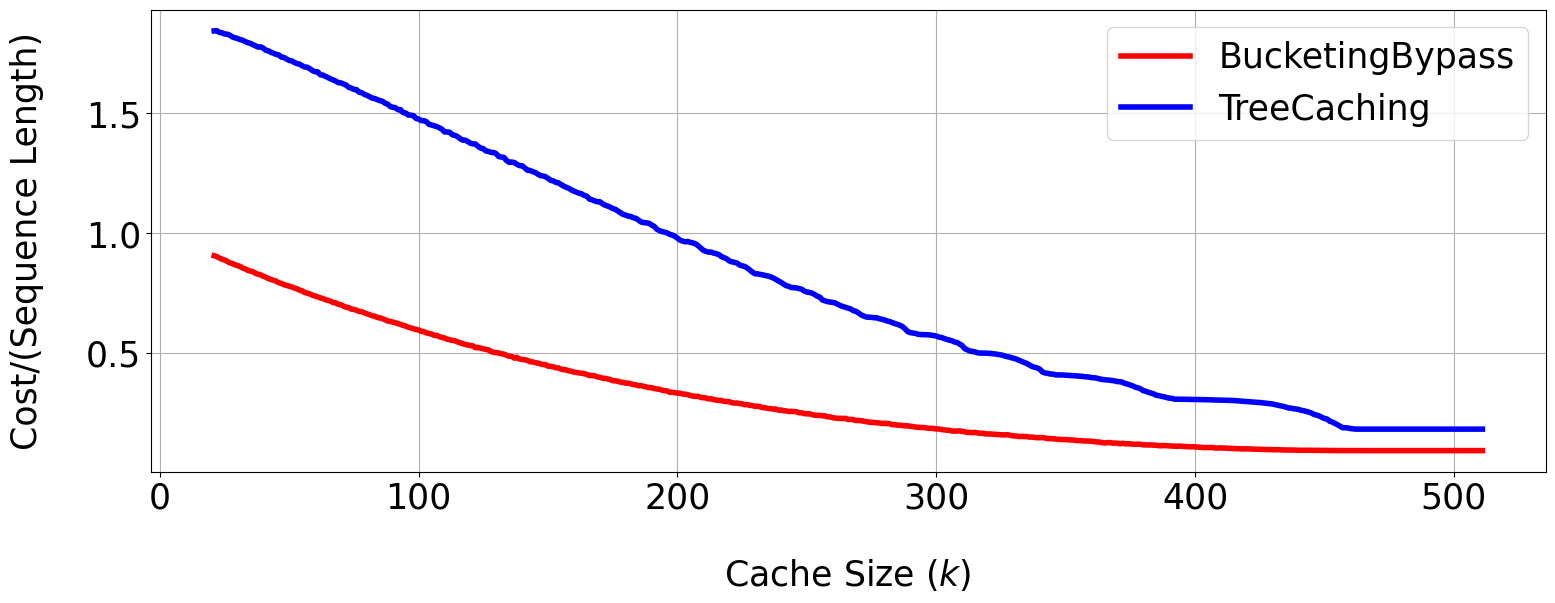

In [11]:
# n = 10
n = 10
plt.figure(figsize=(18,6))
plt.plot(data[data[:,0]>20,0], data[data[:,0]>20,1], 'r', linewidth=4)
plt.plot(data[data[:,0]>20,0], data[data[:,0]>20,2], 'b', linewidth=4)
plt.xlabel(f"Cache Size ($k$)", fontsize=25)
plt.ylabel("Cost/(Sequence Length)", fontsize=25)
plt.grid()
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.yaxis.labelpad = 30
ax.xaxis.labelpad = 30
plt.legend(["BucketingBypass", "TreeCaching"], fontsize=25)

if EXPERIMENT == "zipf":
    filename = f"results/cost_cache_n={n}_zipf_no_perm_levelwise.png"
elif EXPERIMENT == "geo":
    filename = f"results/cost_cache_n={n}_geo_no_perm.png"

plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
plt.show()